# Setup

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
from matplotlib import colors
import random
import plotly.io as pio

In [40]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [41]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
reports_comunidades = "../../../reports/analisis_comunidades/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
graph_edge_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_edges.csv")

disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

G = nx.read_gml(data_processed+"graph_data/grafo_alternativo_CG_disease_layer.gml")
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
nx.relabel_nodes(G,new_labels,False)

,Número de nodos
bert_group,1043
complex,421
disease,15066
gene_protein,17322
pathway,2017
total,35869


,Número de enlaces
disease_disease,17432.0
form_complex,1885.0
gda,84024.0
pathway_protein,42643.0
ppi,110051.0
total,256035.0


# Cartographic Role - Infomap

## Within-module degree:

Para cada nodo $i$, perteneciente a una comunidad $s_{i}$, calculo el "grado interno" $z_i$:

$ z_{i} = \frac{k_{i} - \bar{k}_{s_i}}{\sigma_{k_{si}}}$

Donde $k_i$ es el número de enlaces de $i$ a otros nodos de su comunidad, $\bar{k}_{s_i}$ es el promedio de $k$ sobre todos los nodos de la comunidad y $\sigma_{k_{si}}$ el desvío estandar de $k$ en $s_i$.


In [42]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [43]:
grafos_comunidades = {}

for comunidad in comunidades_infomap:
    nodos = graph_node_data.loc[graph_node_data.comunidades_infomap == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [44]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [45]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_3196/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


Dejo los nan afuera del análisis porque salen de comunidades con sigma=0. Son comunidades chiquitas de 2 nodos que no tiene mucho sentido analizar por ahí.

## Participation coefficient

$P_i = 1 - \sum_{s=1}^{N_M} (\frac{k_{i_s}}{k_i})^2$

Donde $k_{i_s}$ es el número de enlaces del nodo i a nodos del módulo s (sumo sobre todos los módulos) y ${k_i}$ es el grado **total** del nodo i.

In [46]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_infomap"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

## Roles cartográficos

Para cada nodo (solo los BERTs) calculo la región Rn (n = [1,7]) según sus valores de z y p, como dice el paper. Al final de todo hago un gráfico con las regiones (quizás mostrando algunos nodos)

In [47]:
def cartographic_role(z,p):
    #nodos non-hub
    if z < 2.5:
        if p <= 0.05:
            role = 1
        elif p <= 0.62:
            role = 2
        elif p <= 0.8:
            role = 3
        else:
            role = 4

    #nodos hub
    else:
        if p <= 0.3:
            role = 5
        elif p<= 0.75:
            role = 6
        else:
            role = 7
            
    return role

In [48]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [49]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [233]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
non_berts = graph_node_data.loc[graph_node_data.node_type == "disease", "node_index"].values
bert_roles = results_df.loc[berts].sort_values(by="role").reset_index()
non_bert_roles = results_df.loc[results_df.index.intersection(non_berts)].sort_values(by="role").reset_index()

Text(0.5, 1.0, 'Rol cartográfico - Infomap')

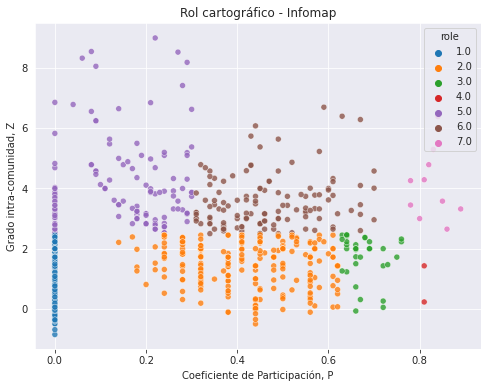

In [78]:
fig,ax = plt.subplots(figsize=(8,6))

joint = sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)

ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")
ax.set_title("Rol cartográfico - Infomap")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_infomap.png",dpi=200)

In [75]:
role_names = {1:"ultra-peripheral", 2:"peripheral",3:"non-hub connector",4:"non-hub kinless",5:"provincial hub",6:"connector hub",7:"kinless hub"}
results_df["role_name"] = results_df.role.apply(lambda x: role_names[x])
color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}

In [232]:
fig = px.scatter(bert_roles, x="participation_coefficient", y="intra_degree",text="index", width=1000, height=600, color="role_name", marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico grupos BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_interactivo.html")

In [244]:
graph_node_data[graph_node_data.node_index == 373]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
371,373,10150_4958_5096_6082_500_514,squamous cell carcinoma,bert_group,primekg,128.0,2.0,0.0,0.0,53.0


In [234]:
fig = px.scatter(non_bert_roles, x="participation_coefficient", y="intra_degree", width=1000, height=600, color="role_name",text="index",marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico nodos no-BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Participation Coefficient - P", yaxis_title="Within-module degree - Z")

fig.show()
fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_interactivo.html")

In [243]:
graph_node_data[graph_node_data.node_index == 21799]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
21584,21799,C0158538,Other congenital anomalies of nervous system,disease,disgenet,3.0,17.0,0.0,0.0,304.0


Los nodos BERT tienen un rol conector dentro de sus comunidades, pero además tienen participación no nula, entonces conectan módulos entre sí. 

Se observan pocos valores negativos: los bert tienden a tener grado mayor a la media del módulo (recordar que el eje y está estandarizado)

Analizar ejemplos de Berts conectores

In [218]:
fig = px.histogram(bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_barras_interactivo.html")

In [219]:
fig = px.histogram(non_bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos no-BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_barras_interactivo.html")

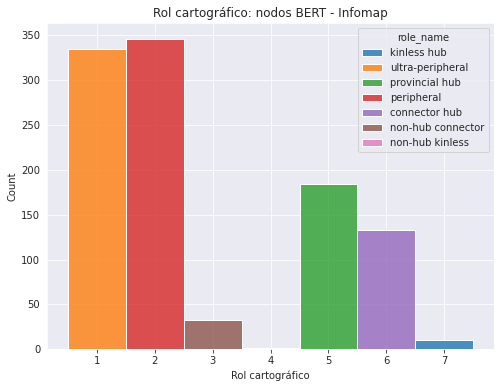

In [206]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos BERT - Infomap")
sns.histplot(data=bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap.png",dpi=200)

Para este grafico sacar los berts 

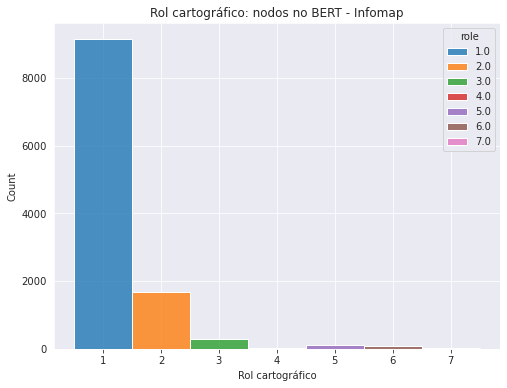

In [53]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=non_bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_title("Rol cartográfico: nodos no BERT - Infomap")
ax.set_xlabel("Rol cartográfico")
fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap_no_berts.png",dpi=200)

# Cartographic Role - Louvain

In [20]:
grafos_comunidades = {}

for comunidad in comunidades_louvain:
    nodos = graph_node_data.loc[graph_node_data.comunidades_louvain == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [21]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [22]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_3196/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


In [23]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_louvain"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

In [24]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [25]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [26]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
bert_roles = results_df.loc[berts]

Text(0.5, 1.0, 'Rol cartográfico - Louvain')

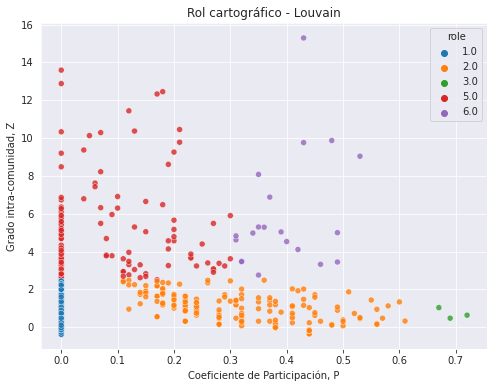

In [27]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)
ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")

ax.set_title("Rol cartográfico - Louvain")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_louvain.png",dpi=200)

Text(0.5, 0, 'Rol cartográfico')

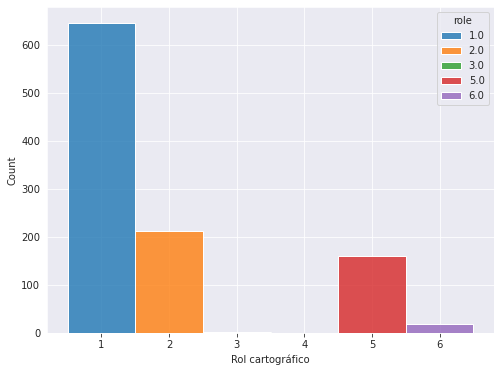

In [28]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain.png",dpi=200)

Text(0.5, 0, 'Rol cartográfico')

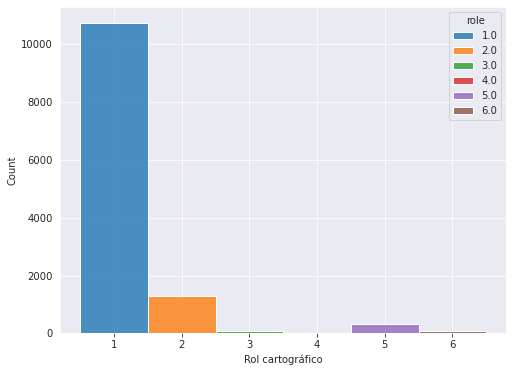

In [29]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=results_df, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain_todos.png",dpi=200)